# Access and visualization of EO Data on the Cloud (COGS)

**Purpose** : 
>Connect to an EO data catalog by using a [SpatioTemporal Asset Catalog (STAC)](https://stacspec.org/) client in Python.\
>Search for data products for a specific region and time period.\
>Display the boundaries of the available scenes\
>Get an overview of the actual images\
>Save band image.

<hr/> 

## 1-import required libraries

In [4]:
# Import necessary packages
import os 
#import cv2
from datetime import date
import json
import itertools
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from sentinelhub import pixel_to_utm, utm_to_pixel
import utm
import pandas as pd
from shapely.geometry import box
from rasterio.mask import mask
from pystac_client import Client
import shapely.geometry
import shapely.wkt
import folium
import shapely.geometry
#from odc.algo import to_rgba
import earthpy.spatial as es
import earthpy.plot as ep
import rioxarray
#import contextily as ctx 

<hr/> 

## 2-Set the AOI

In [10]:
#Set the path to data
aoi_dir = "../../data/aoi"
aoi_file = "littoral_outline.geojson"
aoi_path = os.path.join(aoi_dir , aoi_file )

In [11]:
assert os.path.exists(aoi_path), f'{aoi_path}'

In [12]:
aoi_path

'../../data/aoi/littoral_outline.geojson'

In [101]:
def get_bounds_of_AoI(obj_aoi, offset):
    
    aoi = gpd.read_file(obj_aoi)
    
    bounds = aoi.total_bounds
    #offset = 1/60  #200m in degree
    # Extend the bounding box by 200 m
    minx, miny = bounds[0]-offset, bounds[1]-offset
    maxx, maxy = bounds[2]+offset, bounds[3]+offset

    bbox = box(minx, miny, maxx, maxy)
    
    print(bbox)

    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

    
    return  geo

In [102]:
#offset = 1/60  #200m in degree
bbx = get_bounds_of_AoI(aoi_path, 1/60)
aoi = gpd.read_file(aoi_path)

POLYGON ((11.094414006666668 3.243667343333333, 11.094414006666668 5.351516026666666, 9.319134458233293 5.351516026666666, 9.319134458233293 3.243667343333333, 11.094414006666668 3.243667343333333))


In [103]:
bbx.explore()

<hr/> 

## 3-Search a STAC catalog

In [78]:
# STAC API endpoint
api_url = "https://earth-search.aws.element84.com/v0"
client = Client.open(api_url)
collection = "sentinel-s2-l2a-cogs"  # Sentinel-2, Level 2A, COGs

In [79]:
print(bbx.crs)
values = []
for i in range(len(bbx.total_bounds)):
    values.append(bbx.total_bounds[i])
keys = ["lonmin", "latmin", "lonmax", "latmax"]  
geometry = dict(zip(keys, values))

EPSG:4326


In [80]:
time =  ["2021-02-01", "2021-02-15"]
search = client.search(
    collections=[collection],
    bbox= [ geometry["lonmin"], geometry["latmin"],  geometry["lonmax"], geometry["latmax"]],
    datetime = ["2023-01-01", "2023-01-15"],
    #limit=100,
    query=["eo:cloud_cover<0.01"]
)
print(search.matched())

2


In [81]:
items = search.get_all_items()
items.save_object("search.json")

<hr/> 

## 4-Access the assets

In [83]:
assets = items[0].assets  # first item's asset dictionary
print(assets.keys())

dict_keys(['thumbnail', 'overview', 'info', 'metadata', 'visual', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'AOT', 'WVP', 'SCL'])


In [84]:
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

thumbnail: Thumbnail
overview: True color image
info: Original JSON metadata
metadata: Original XML metadata
visual: True color image
B01: Band 1 (coastal)
B02: Band 2 (blue)
B03: Band 3 (green)
B04: Band 4 (red)
B05: Band 5
B06: Band 6
B07: Band 7
B08: Band 8 (nir)
B8A: Band 8A
B09: Band 9
B11: Band 11 (swir16)
B12: Band 12 (swir22)
AOT: Aerosol Optical Thickness (AOT)
WVP: Water Vapour (WVP)
SCL: Scene Classification Map (SCL)


In [85]:
visual_href = assets["visual"].href
visual = rioxarray.open_rasterio(visual_href)

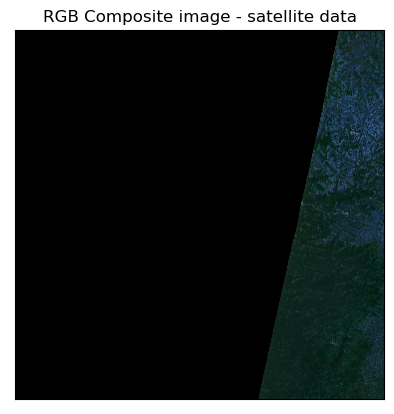

In [40]:
#Plot the RGB composite
f, ax = plt.subplots()
ep.plot_rgb(visual.values,
            rgb=[2, 1, 0],
            title="RGB Composite image - satellite data",
                ax=ax)
plt.show()

In [ ]:
#Save RGB to Disk
#visual.rio.to_raster("visual00.tif")

In [105]:
visual.rio.write_crs("epsg:4326", inplace=True)

print(visual.rio.crs)

EPSG:4326


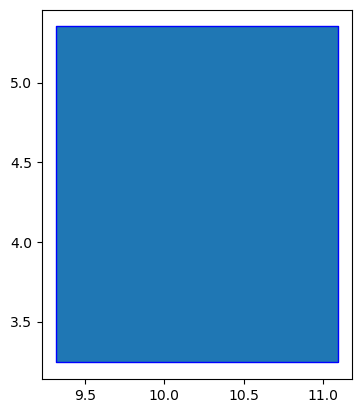

,geometry
0,"POLYGON ((11.09441 3.24367, 11.09441 5.35152, ..."


In [106]:
f, ax = plt.subplots()
visual.plot.imshow(ax=ax, ec = 'b')
aoi.plot(ax=ax)
plt.show()
bbx

In [31]:
#Access band 2
b02_href = assets["B02"].href
b02 = rioxarray.open_rasterio(b02_href)
#b02.rio.to_raster("B02.tif")

In [32]:
#Access band 3
b03_href = assets["B03"].href
b03 = rioxarray.open_rasterio(b03_href)
#b03.rio.to_raster("B03.tif")

In [33]:
#Access Band 4
b04_href = assets["B04"].href
b04 = rioxarray.open_rasterio(b04_href)
#b04.rio.to_raster("B04.tif")

In [ ]:
# Acces SCL: Scene Classification Map (SCL)
bscl_href = assets["SCL"].href
bscl = rioxarray.open_rasterio(bscl_href)
bscl.rio.to_raster("SCL.tif")

In [ ]:
#Access Band 8
b08_href = assets["B08"].href
b08 = rioxarray.open_rasterio(b08_href)
#b08.rio.to_raster("B08.tif")

### Stack all bands in the same array

In [ ]:
import xarray as xr
ds = np.vstack([b04, b03, b02, b08]) # RGB NIR
# Create xr.DataArray to write netcdf
df = xr.DataArray(ds, dims=['Bands','x','y'])

In [ ]:
# Save to netcdf
PATH_ncdf = ' ' # Add the path 
file_name = os.path.join(PATH_ncdf,"file_all_bands.nc")
df.to_netcdf(file_name)

In [ ]:
# Open it again
data = xr.open_dataset(file_name)